In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Preprocessing

In [2]:
def preprocess_data_with_target(df, target):
    """
    Preprocess dataset with target variable:
      - Handles missing values
      - Encodes categorical features
      - Standardizes numerical features
      - Separates features (X) and target (y)
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to preprocess.
    target : str
        The name of the target column.

    Returns
    -------
    X : pandas.DataFrame
        Processed feature matrix
    y : pandas.Series
        Encoded target column
    encoders : dict
        LabelEncoders used for categorical columns
    scaler : StandardScaler
        Scaler fitted on numeric columns
    """

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # Handle Missing Values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # numeric
            df[col] = df[col].fillna(df[col].mean())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

    # Separate Features and Target
    X = df.drop(columns=[target])
    y = df[target]

    # Encode Categorical Columns
    encoders = {}
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders[col] = le

    # Encode target if categorical
    if y.dtype == 'object' or str(y.dtype) == 'category':
        le_target = LabelEncoder()
        y = le_target.fit_transform(y)
        encoders[target] = le_target

    # Standardize Numerical Features
    scaler = StandardScaler()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    print(f"\n********************* \nFirst 5 Rows of X after transformation: \n{X.head()}\n*********************")
    print(f"First 5 Rows of y after transformation: \n{y[:5]}\n********************* \n")

    return X, y, encoders, scaler


In [3]:
def preprocess_data_no_target(df):
    """
    Preprocess dataset without a target variable:
      - Handles missing values
      - Encodes categorical features
      - Standardizes numerical features

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to preprocess.

    Returns
    -------
    X : pandas.DataFrame
        Processed feature matrix
    encoders : dict
        LabelEncoders used for categorical columns
    scaler : StandardScaler
        Scaler fitted on numeric columns
    """

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # ---- Handle Missing Values ----
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # numeric
            df[col] = df[col].fillna(df[col].mean())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

    # ---- Encode Categorical Columns ----
    encoders = {}
    for col in df.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

    # ---- Standardize Numerical Features ----
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    print(f"\n********************* \nFirst 5 Rows of Data after transformation: \n{df.head()}\n*********************")

    return df, encoders, scaler


In [4]:
# Load project_adult.csv as pa
pa = pd.read_csv("project_adult.csv")

# Apply preprocess function on pa
pa_X, pa_y, pa_encoders, pa_scaler = preprocess_data_with_target(df = pa, target = "income")

First 5 Rows of Data before transformation: 
   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0        5514   33         Local-gov  198183     Bachelors             13   
1       19777   36           Private   86459     Assoc-voc             11   
2       10781   58  Self-emp-not-inc  203039           9th              5   
3       32240   21           Private  180190     Assoc-voc             11   
4        9876   27           Private  279872  Some-college             10   

       marital-status       occupation   relationship   race     sex  \
0       Never-married   Prof-specialty  Not-in-family  White  Female   
1  Married-civ-spouse  Exec-managerial        Husband  White    Male   
2           Separated     Craft-repair  Not-in-family  White    Male   
3  Married-civ-spouse  Farming-fishing        Husband  White    Male   
4            Divorced    Other-service  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week native-countr

In [5]:
# Load project_validation_inputs.csv as pv
pv = pd.read_csv("project_validation_inputs.csv")

# Apply preprocess function on pa
pv_X, pv_encoders, pv_scaler = preprocess_data_no_target(df = pv)

First 5 Rows of Data before transformation: 
   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0       14160   27           Private  160178  Some-college             10   
1       27048   45         State-gov   50567       HS-grad              9   
2       28868   29           Private  185908     Bachelors             13   
3        5667   30           Private  190040     Bachelors             13   
4        7827   29  Self-emp-not-inc  189346  Some-college             10   

       marital-status         occupation   relationship   race     sex  \
0            Divorced       Adm-clerical  Not-in-family  White  Female   
1  Married-civ-spouse    Exec-managerial           Wife  White  Female   
2  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
3       Never-married  Machine-op-inspct  Not-in-family  White  Female   
4            Divorced       Craft-repair  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week n

# Logistic Regression

In [6]:
# Split data into train/test
pa_X_train, pa_X_test, pa_y_train, pa_y_test = train_test_split(
    pa_X, pa_y, test_size=0.2, random_state=42, stratify=pa_y
)

In [7]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
# np.logspace(-4,4,20) tells GridSearchCV to test 20 values for C 
# evenly spaced on a logarithmic scale from 10^-4 to 10^4
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='sag', random_state=42, max_iter=200),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(pa_X_train, pa_y_train)

# Get the best estimator from the search.
pa_log_best_model = grid_search.best_estimator_

print("\n--- Best Logistic Regression Model ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
pa_y_pred_final = pa_log_best_model.predict(pa_X_test)
pa_final_accuracy = accuracy_score(pa_y_test, pa_y_pred_final)

print(f"Final accuracy on test set: {pa_final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(pa_y_test, pa_y_pred_final))

print("\nConfusion Matrix:")
pa_cm = confusion_matrix(pa_y_test, pa_y_pred_final)
print(pa_cm)

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Best Logistic Regression Model ---
Best parameters: {'C': 4.281332398719396}
Best cross-validation accuracy: 0.8254

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8259

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3956
           1       0.72      0.46      0.56      1254

    accuracy                           0.83      5210
   macro avg       0.78      0.70      0.72      5210
weighted avg       0.81      0.83      0.81      5210


Confusion Matrix:
[[3731  225]
 [ 682  572]]


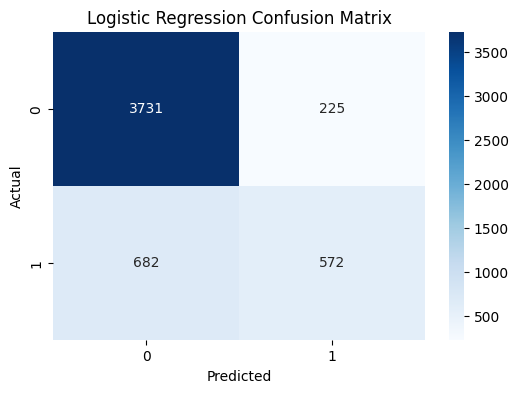

In [8]:
# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(pa_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(pa_y),
            yticklabels=np.unique(pa_y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


Top 2 features for visualization: ['education-num', 'capital-gain']


/Users/jmlaurie/miniconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


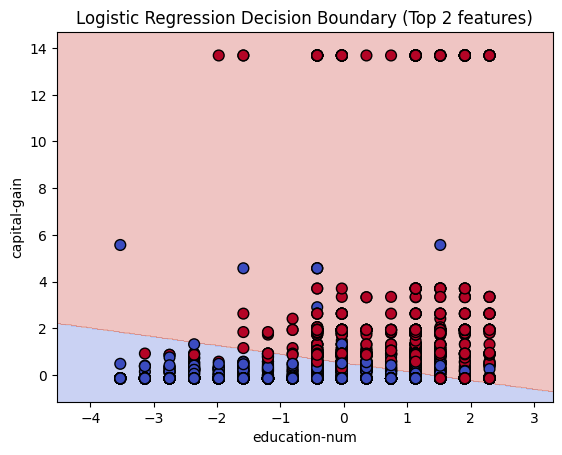

In [9]:

# Visualization of Decision Boundary with Top 2 Features

# Get absolute values of coefficients for feature importance
coef_importance = np.abs(pa_log_best_model.coef_[0])

# Get indices of the two most important features
top2_idx = np.argsort(coef_importance)[-2:]
print("Top 2 features for visualization:", pa_X.columns[top2_idx].tolist())

# Select those 2 features
pa_X_vis = pa_X.iloc[:, top2_idx]
pa_y_vis = pa_y

# Retrain logistic regression with only these 2 features
pa_log_vis = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200, C=pa_log_best_model.C)
pa_log_vis.fit(pa_X_vis, pa_y_vis)

# Create meshgrid for plotting decision regions
x_min, x_max = pa_X_vis.iloc[:, 0].min() - 1, pa_X_vis.iloc[:, 0].max() + 1
y_min, y_max = pa_X_vis.iloc[:, 1].min() - 1, pa_X_vis.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict grid points
Z = pa_log_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and data
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(pa_X_vis.iloc[:, 0], pa_X_vis.iloc[:, 1], c=pa_y_vis,
            edgecolors='k', cmap=plt.cm.coolwarm, s=60)

plt.xlabel(pa_X.columns[top2_idx[0]])
plt.ylabel(pa_X.columns[top2_idx[1]])
plt.title("Logistic Regression Decision Boundary (Top 2 features)")
plt.show()


In [10]:
validation_preds = pa_log_best_model.predict(pv_X.values)

# Map predictions back to original income labels if target_le available
target_le = pa_encoders.get("income")
if target_le is not None:
    readable_preds = target_le.inverse_transform(validation_preds)
    output_df = pv.copy()
    output_df['Predicted_Income'] = readable_preds
else:
    output_df = pv.copy()
    output_df['Predicted_Income'] = validation_preds

# save just output labels using LogisticRegression model output filename
output_df[['Predicted_Income']].to_csv("Group_23_LogisticRegression_PredictedOutputs.csv", index=False)
print("Validation predictions saved to Group_23_LogisticRegression_PredictedOutputs.csv")
# ...existing code...

Validation predictions saved to Group_23_LogisticRegression_PredictedOutputs.csv


/Users/jmlaurie/miniconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
